In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentparentdir)

In [2]:
import pandas as pd
import random
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign

from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from copy import copy
from visualization.visualization import draw_BN, draw_comparative_hist, get_probability
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from core.core_utils import project_root
from external.pyBN.utils.independence_tests import mutual_information, entropy, mi_from_en
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
import seaborn as sns
import sklearn.metrics as skm
import scipy.stats as ss
from scipy.spatial.distance import cdist
from external.libpgm.sampleaggregator import SampleAggregator
from sklearn.metrics import accuracy_score, mean_squared_error
import operator
from typing import Tuple
import json
from bayesian.sampling import generate_synthetics
from graph.precision_recall import child_dict
from visualization.visualization import get_probability, grouped_barplot
from bayesian.calculate_accuracy import parall_accuracy

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
data = pd.read_csv(f'{project_root()}/data/SCADI.csv')
data.reset_index(drop=True, inplace=True)
print(set(data.dtypes))

{dtype('O'), dtype('int64')}


In [5]:
print(data.columns)

Index(['Gender', 'Age', 'd 5100-0', 'd 5100-1', 'd 5100-2', 'd 5100-3',
       'd 5100-4', 'd 5100-8', 'd 5100-9', 'd 5101-0',
       ...
       'd 57022-8', 'd 57022-9', 'd 571-0', 'd 571-1', 'd 571-2', 'd 571-3',
       'd 571-4', 'd 571-8', 'd 571-9', 'Classes'],
      dtype='object', length=206)


In [6]:
boarders = [1, 50, 100]
interesting = {}
for var in list(data.columns):
    count = len(set(data[var].values))
    if (count> boarders[1]):
        if data[var].dtype == 'O':
            print(var)
        interesting[var] = count
sorted_tuples = sorted(interesting.items(), key=lambda item: item[1])
sorted_dict = {k: v for k, v in sorted_tuples}
sorted_dict


{}

In [7]:
# boarder = 50
# interesting = {}
# for var in list(data.columns):
#     count = len(set(data[var].values))
#     if (count> boarder):
#         data[var] = data[var].apply(lambda x: float(x))
#     else:
#         data[var] = data[var].apply(lambda x: str(x))
# #data['city_id'] = data['city_id'].apply(lambda x: int(x)).apply(lambda x: str(x))


In [8]:
col_inter = list(data.columns)

In [9]:
data=data[col_inter]

In [10]:
print(len(data))

70


In [11]:
data = data.dropna()

In [12]:
print(len(data))

70


In [13]:
#data = data.sample(n=400, random_state=1)

In [14]:
"""small_columns = []
for var in data_types:
    if data_types[var] != 'disc':
        if data[var].max()-data[var].min() < 1.0:
            small_columns.append(var)
data.drop(small_columns, axis=1, inplace=True)"""

"small_columns = []\nfor var in data_types:\n    if data_types[var] != 'disc':\n        if data[var].max()-data[var].min() < 1.0:\n            small_columns.append(var)\ndata.drop(small_columns, axis=1, inplace=True)"

In [15]:
data_types = get_nodes_type(data)

In [16]:
colums_for_code = []
columns_for_disc = []
for c in data.columns:
    if data_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [17]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete = copy(data_coded)

In [18]:
def su_dist(x, y): 
    #print(x)
    #print(y)
    #z = np.concatenate((np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)), axis=1)
    #z = np.concatenate((x, y), axis=1)
    """if (entropy(x) + entropy(y)) == 0.0:
        print(mi_from_en(z))
        return 0.0
    else:
        return - 2 * mi_from_en(z) / (entropy(x) + entropy(y))"""
    return 1.0 - normalized_mutual_info_score(x, y)

In [19]:
column = list(data.columns)
D = [[0.0 for i in column] for j in column]
for i, var1 in enumerate(column):
    for j, var2 in enumerate(column):
        D[i][j] = su_dist(data_discrete[var1].values, data_discrete[var2].values)
#D = np.where(np.isnan(D), 0.0, D)    


In [20]:
alpha = 0.5

res_dict = {}


model = AgglomerativeClustering(distance_threshold=alpha, n_clusters=None, affinity='precomputed', linkage='single')
model = model.fit_predict(D)

for i, val in enumerate(model):
    if val in res_dict:
        res_dict[val].append(column[i])
    else:
        res_dict[val] = [column[i]]
for key, val in res_dict.items():
    if len(val) > 1:
        print(val)

['d 5100-0', 'd 5101-1', 'd 5102-0', 'd 5200-0', 'd 5201-0', 'd 5202-0', 'd 5203-1', 'd 5204-1', 'd 5205-0', 'd 5400-0', 'd 5401-0', 'd 5402-0', 'd 5403-0', 'd 5501-0', 'd 5602-0']
['d 5100-1', 'd 5400-1', 'd 5401-1', 'd 5402-1']
['d 5100-4', 'd 5101-4', 'd 5102-4', 'd 5200-4', 'd 5201-4', 'd 5202-4', 'd 5203-4', 'd 5204-4', 'd 5205-4', 'd 53001-4', 'd 53011-4', 'd 5400-4', 'd 5401-4', 'd 5402-4', 'd 5403-4', 'd 5501-4', 'd 5602-4', 'Classes']
['d 5100-8', 'd 5100-9', 'd 5101-0', 'd 5101-8', 'd 5101-9', 'd 5102-8', 'd 5102-9', 'd 5200-8', 'd 5200-9', 'd 5201-8', 'd 5201-9', 'd 5202-8', 'd 5202-9', 'd 5203-8', 'd 5203-9', 'd 5204-8', 'd 5204-9', 'd 5205-8', 'd 5205-9', 'd 53000-8', 'd 53000-9', 'd 53001-8', 'd 53001-9', 'd 53010-8', 'd 53010-9', 'd 53011-8', 'd 53011-9', 'd 5302-0', 'd 5302-1', 'd 5302-8', 'd 5400-8', 'd 5400-9', 'd 5401-8', 'd 5401-9', 'd 5402-8', 'd 5402-9', 'd 5403-8', 'd 5403-9', 'd 5404-3', 'd 5404-8', 'd 5404-9', 'd 5500-3', 'd 5500-8', 'd 5500-9', 'd 5501-8', 'd 

In [21]:
"""linkage_matrix = linkage(D, "single")
dendrogram(linkage_matrix, labels=column)
plt.title("test")
plt.show()"""

'linkage_matrix = linkage(D, "single")\ndendrogram(linkage_matrix, labels=column)\nplt.title("test")\nplt.show()'

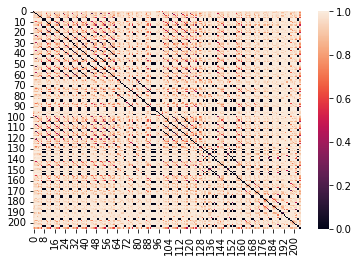

In [22]:
ax = sns.heatmap(D)

<ipython-input-23-a9763bb72b78>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


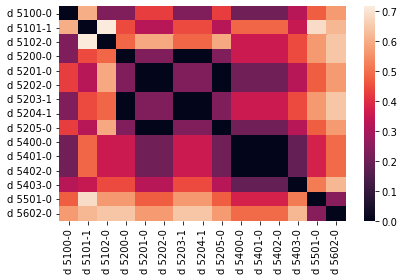

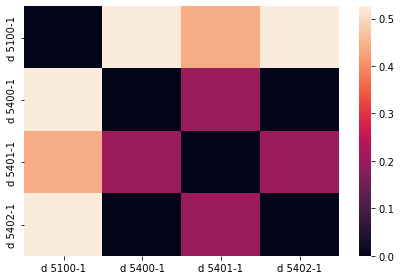

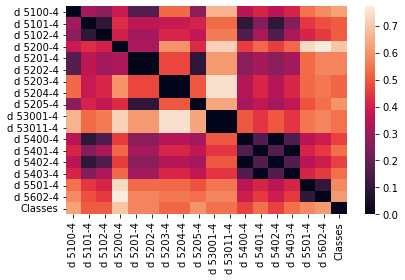

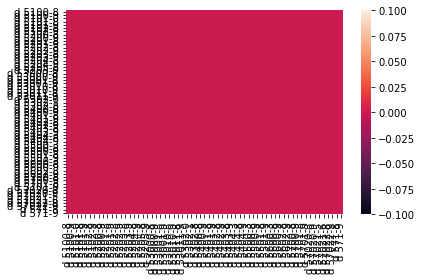

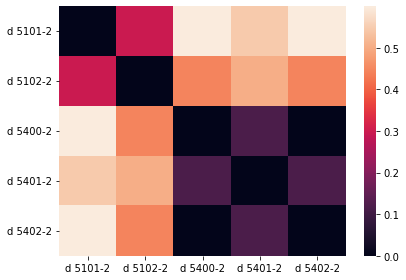

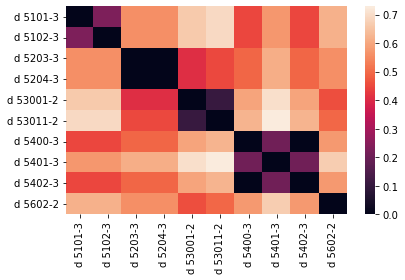

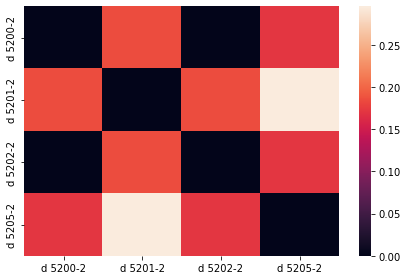

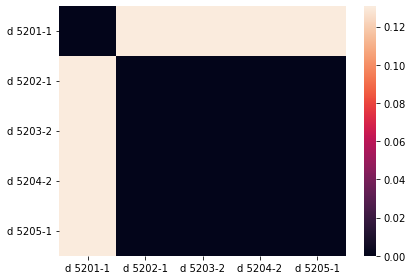

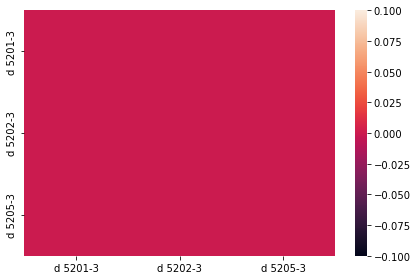

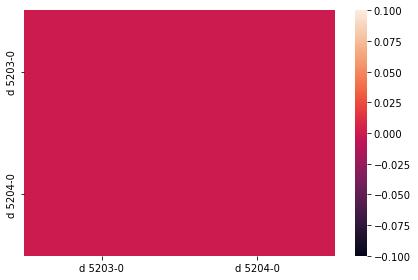

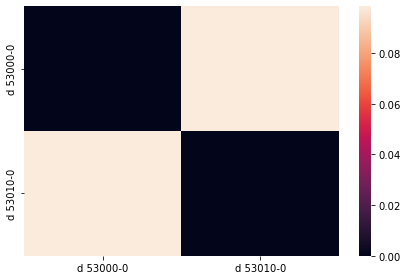

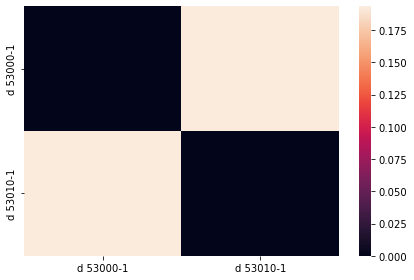

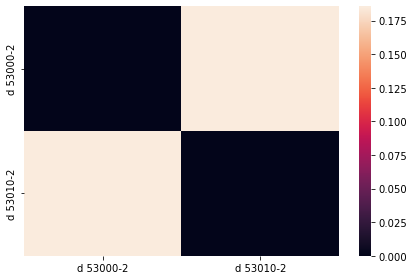

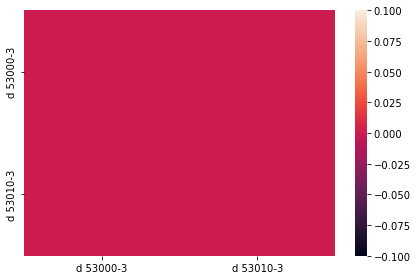

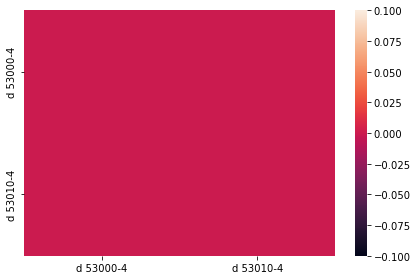

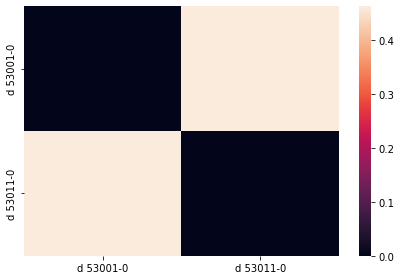

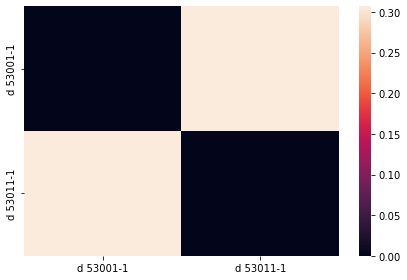

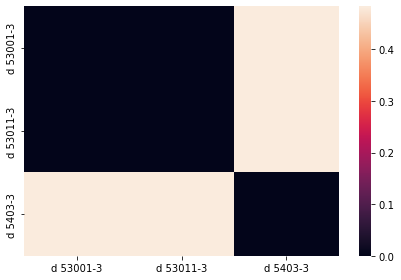

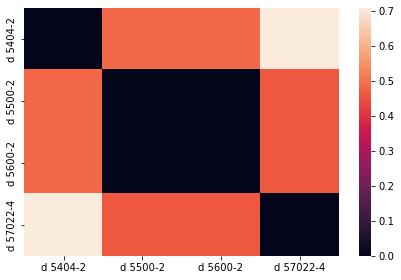

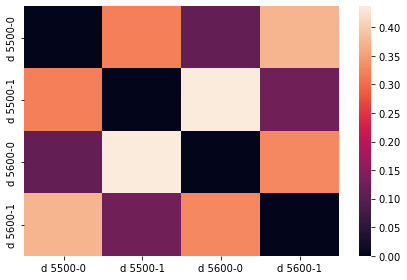

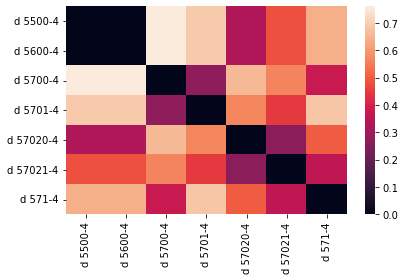

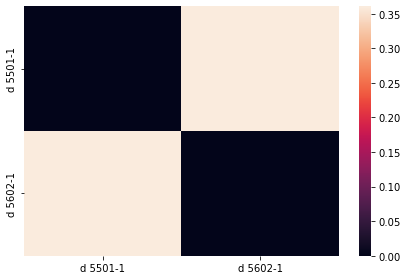

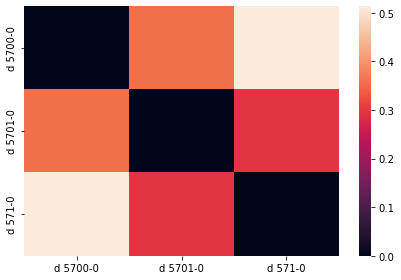

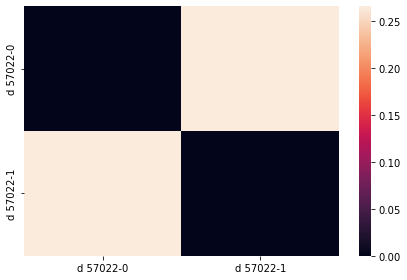

In [23]:
label_dict = {var: var for var in column}
label_dict['Depositional system'] = 'Dep. sys.'
label_dict['Depositional environment'] = 'Dep. env.'
ind_dict = {}
for i, val in enumerate(model):
    if val in ind_dict:
        ind_dict[val].append(i)
    else:
        ind_dict[val] = [i]
count = 0
for key, val in ind_dict.items():
    if len(val) > 1:
        count += 1

g = [None for _ in range(count)]
ind = 0
for key, val in ind_dict.items():
    if len(val) > 1:
        loc_D = [[D[i][j] for j in val] for i in val]
        fig, ax = plt.subplots()
        ax = sns.heatmap(loc_D, xticklabels=[label_dict[column[i]] for i in val], yticklabels=[label_dict[column[i]] for i in val])
        plt.tight_layout()
        name = str([column[i] for i in val])
        plt.savefig(name[:min(70, len(name))])
        #fig.clear()
        ind += 1

In [24]:
def zip_code(data_discrete: pd.DataFrame, cluster_columns: list, alpha: float = 0.95, low_limit: int = 30):
    group = copy(data_discrete).groupby(cluster_columns)
    comb = group.size().reset_index().rename(columns={0:'count'})
    comb['count'] = comb['count'] / len(data_discrete)
    comb.sort_values(by=['count'], inplace=True, ascending=False)
    sum = 0.0
    ind = 0
    #while (sum < alpha) & (comb.iloc[ind]['count'] >= low_limit / len(data_discrete)):
    while (sum < alpha):
        sum += comb.iloc[ind]['count']
        ind += 1
        if ind == len(comb):
            break

    x, _ = code_categories(comb, 'onehot', cluster_columns)
    x = x.values
    if ind < len(comb):
        dists = cdist(x[ind:, :], x[:ind, :], metric='hamming')
        neighbors_map = [list(np.where(row == row.min())[0]) for row in dists]
        neighbors_map = [args[-1] for args in neighbors_map]
        better = [i if (i < ind) else neighbors_map[i - ind] for i in range(len(comb))]
    else:
        better = [i for i in range(len(comb))]

    code_col = [None for _ in range(len(data_discrete))]
    for i in range(len(comb)):
        merged_values = tuple(comb[cluster_columns].iloc[i])
        for j in group.indices[merged_values]:
            code_col[j] = better[i]

    return code_col

In [25]:
df2 = pd.DataFrame()
for key, val in res_dict.items():
    if len(val) > 1:
        code_col = zip_code(data_discrete, val)
        df2[tuple(val)] = code_col
    else:
        df2[tuple(val)] = data_discrete[val[0]]

In [26]:
tuple_columns = df2.columns
rename_dict = {tuple_columns[i]: i  for i in range(len(tuple_columns))}
df2.rename(rename_dict, axis = 1, inplace=True)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0,11,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,13,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,11,0,0,0,1,16,0,0,12,...,0,1,0,0,0,0,0,0,0,1
3,1,11,0,0,0,0,4,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,12,0,0,0,0,12,0,0,2,...,0,1,0,0,0,0,0,0,1,0


In [27]:
bn_without = structure_learning(data_discrete, 'HC', get_nodes_type(data), 'K2', cont_disc = False)

In [ ]:
draw_BN(bn_without, {var: 'disc' for var in bn_without['V']}, f'rename_scadi_' + 'full')

In [ ]:
#draw_BN(bn_without, {var: 'disc' for var in bn_without['V']}, 'without_full_net')

In [ ]:
node_type = {}
for key, val in rename_dict.items():
    if len(key) > 1:
        node_type[val] = 'dict'
    else:
        node_type[val] = data_types[key[0]]
    

In [ ]:
node_type

{0: 'disc',
 1: 'disc',
 2: 'dict',
 3: 'dict',
 4: 'disc',
 5: 'disc',
 6: 'dict',
 7: 'dict',
 8: 'dict',
 9: 'dict',
 10: 'disc',
 11: 'disc',
 12: 'dict',
 13: 'disc',
 14: 'dict',
 15: 'dict',
 16: 'dict',
 17: 'dict',
 18: 'dict',
 19: 'dict',
 20: 'dict',
 21: 'dict',
 22: 'dict',
 23: 'dict',
 24: 'dict',
 25: 'disc',
 26: 'disc',
 27: 'disc',
 28: 'disc',
 29: 'disc',
 30: 'disc',
 31: 'disc',
 32: 'disc',
 33: 'dict',
 34: 'disc',
 35: 'dict',
 36: 'dict',
 37: 'dict',
 38: 'disc',
 39: 'disc',
 40: 'disc',
 41: 'dict',
 42: 'disc',
 43: 'disc',
 44: 'disc',
 45: 'disc',
 46: 'disc',
 47: 'disc',
 48: 'disc',
 49: 'disc',
 50: 'disc',
 51: 'disc',
 52: 'disc',
 53: 'disc',
 54: 'disc',
 55: 'disc',
 56: 'dict',
 57: 'disc',
 58: 'disc',
 59: 'disc',
 60: 'disc',
 61: 'disc'}

In [ ]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0,11,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,13,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,11,0,0,0,1,16,0,0,12,...,0,1,0,0,0,0,0,0,0,1
3,1,11,0,0,0,0,4,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,12,0,0,0,0,12,0,0,2,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
bn = structure_learning(df2, 'HC', node_type, 'BIC', cont_disc = False)

In [ ]:
rerename_dict = {val: str(key) for key, val in rename_dict.items()}
bn_rename = copy(bn)
bn_rename['V'] = [rerename_dict[var] for var in bn_rename['V']]
bn_rename['E'] = [[rerename_dict[var1], rerename_dict[var2]]  for var1, var2 in bn_rename['E']]

In [ ]:
#draw_BN(bn_rename, {rerename_dict[key]: val for key, val in node_type.items()}, 'coded_vars')

In [ ]:
bn_dict = dict()
for key, val in res_dict.items():
    if len(val) > 1:
        bn_loc = structure_learning(data_discrete[val], 'HC', {key_t: val_t for key_t, val_t in data_types.items() if key_t in val}, 'BIC', cont_disc = True)
        bn_dict[str(tuple(val))] = bn_loc
#bn_dict

In [ ]:
bn_full = copy(bn_rename)
for key, bn_loc in bn_dict.items():
    bn_full['V'].extend(bn_loc['V'])
    bn_full['V'].remove(key)
    bn_full['V'].extend([key+"_in", key+'_out'])
    for i in range(len(bn_full['E'])):
        e0, e1 = bn_full['E'][i]
        if e0 == key:
            bn_full['E'][i] = [key+'_out', e1]
        if e1 == key:
            bn_full['E'][i] = [e0, key+'_in']
    bn_full['E'].extend(bn_loc['E'])
    bn_full['E'].extend([[key+'_in', var] for var in bn_loc['V']])
    bn_full['E'].extend([[var, key+'_out'] for var in bn_loc['V']])

In [ ]:
#print(bn_full['V'])
rerename_dict_new = dict() 
for var in bn_full['V']:
    if (',)' in var):
        rerename_dict_new[var] = eval(var)[0]
    else:
        rerename_dict_new[var] = var
bn_full_rename = copy(bn_full)
bn_full_rename['V'] = [rerename_dict_new[var] for var in bn_full_rename['V']]
bn_full_rename['E'] = [[rerename_dict_new[var1], rerename_dict_new[var2]]  for var1, var2 in bn_full_rename['E']]
print(bn_full_rename['V'])

['Gender', 'Age', 'd 5100-2', 'd 5100-3', 'd 5102-1', 'd 5200-1', 'd 5200-3', 'd 5302-2', 'd 5302-3', 'd 5302-4', 'd 5302-9', 'd 5403-1', 'd 5403-2', 'd 5404-0', 'd 5404-1', 'd 5404-4', 'd 5501-2', 'd 5501-3', 'd 5602-3', 'd 5700-1', 'd 5700-2', 'd 5700-3', 'd 5701-1', 'd 5701-2', 'd 5701-3', 'd 57020-0', 'd 57020-1', 'd 57020-2', 'd 57020-3', 'd 57021-0', 'd 57021-1', 'd 57021-2', 'd 57021-3', 'd 57022-2', 'd 57022-3', 'd 571-1', 'd 571-2', 'd 571-3', 'd 5100-0', 'd 5101-1', 'd 5102-0', 'd 5200-0', 'd 5201-0', 'd 5202-0', 'd 5203-1', 'd 5204-1', 'd 5205-0', 'd 5400-0', 'd 5401-0', 'd 5402-0', 'd 5403-0', 'd 5501-0', 'd 5602-0', "('d 5100-0', 'd 5101-1', 'd 5102-0', 'd 5200-0', 'd 5201-0', 'd 5202-0', 'd 5203-1', 'd 5204-1', 'd 5205-0', 'd 5400-0', 'd 5401-0', 'd 5402-0', 'd 5403-0', 'd 5501-0', 'd 5602-0')_in", "('d 5100-0', 'd 5101-1', 'd 5102-0', 'd 5200-0', 'd 5201-0', 'd 5202-0', 'd 5203-1', 'd 5204-1', 'd 5205-0', 'd 5400-0', 'd 5401-0', 'd 5402-0', 'd 5403-0', 'd 5501-0', 'd 560

In [ ]:
rename_dict = {str(key): val for key, val in rename_dict.items()}

In [ ]:
#data_add = copy(data)
data_add = copy(data_discrete)
for key in bn_full_rename['V']:
    if ')_in' in key:
        data_add[key] = df2[rename_dict[key[:-3]]]
    if ')_out' in key:
        data_add[key] = df2[rename_dict[key[:-4]]]
        

In [ ]:
print(len(data.columns))

206


In [ ]:
rename_again = {var: str(i) for i, var in enumerate(data_add.columns)}
#rename_again

In [ ]:
rename_again_inv = {i: var for var, i in rename_again.items()}

In [ ]:
data_add.rename(rename_again, axis=1, inplace=True)
data_add.head()
        

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,0,11,0,0,0,0,1,0,0,0,...,1,1,2,2,0,0,0,0,0,0
1,0,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,11,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,12,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
bn_full_rename_again = copy(bn_full_rename)
bn_full_rename_again['V'] = [rename_again[var] for var in bn_full_rename['V']]
bn_full_rename_again['E'] = [[rename_again[var1], rename_again[var2]]  for var1, var2 in bn_full_rename['E']]
#bn_full_rename_again
        

In [ ]:
nodes_loc_net = {}
full_net = copy(bn_full_rename_again)
for var in full_net['V']:
    if ')_' not in rename_again_inv[var]:
        nodes_loc_net[var] = {'V': [var], 'E': []}
        nodes_loc = set([var])
        for e0, e1 in full_net['E']:
            if e1 == var:
                nodes_loc_net[var]['E'].append([e0, e1])
                nodes_loc.add(e0)
                if (')_out' in rename_again_inv[e0]) or (')_in' in rename_again_inv[e0]):
                    for e2, e3 in full_net['E']:
                        if (e3 == e0) and (e2 != var):
                            nodes_loc_net[var]['E'].append([e2, e3])
                            nodes_loc.add(e2)
        
        nodes_loc_net[var]['V'] = list(nodes_loc)
#print(nodes_loc_net)




In [ ]:
for key, val in nodes_loc_net.items():  
    draw_BN(val, {var: 'disc' for var in val['V']}, f'local_net_for_{rename_again_inv[key]}')

In [ ]:
save_structure(bn_full_rename, 'coded_vars_full_geo_net')

In [ ]:
#draw_BN(bn_full_rename, {var: 'disc' for var in bn_full_rename['V']}, 'coded_full_net')

In [ ]:
nodes_type_add = get_nodes_type(data_add)

In [ ]:
ind = 1 
nodes_loc_param = {}
for key, val in nodes_loc_net.items():
    if any([')_' in rename_again_inv[var] for var in val['V']]):
        try:
            params = parameter_learning(data_add[val['V']], {key1: val1 for key1, val1 in nodes_type_add.items() if key1 in val['V']}, val, 'simple', 'kNN')
            nodes_loc_param[key] = params
            save_params(params, f'coded_vars_full_param_{rename_again_inv[key]}')
            print('success')
        except:
            print(ind)
            ind += 1


In [ ]:
bn_without_rename_again = copy(bn_without)
bn_without_rename_again['V'] = [rename_again[var] for var in bn_without['V']]
bn_without_rename_again['E'] = [[rename_again[var1], rename_again[var2]]  for var1, var2 in bn_without['E']]

In [ ]:
nodes_without_loc_net = {}
full_net = copy(bn_without_rename_again)
for var in full_net['V']:
    if ')_' not in rename_again_inv[var]:
        nodes_without_loc_net[var] = {'V': [var], 'E': []}
        nodes_loc = set([var])
        for e0, e1 in full_net['E']:
            if e1 == var:
                nodes_without_loc_net[var]['E'].append([e0, e1])
                nodes_loc.add(e0)
                if (')_out' in rename_again_inv[e0]) or (')_in' in rename_again_inv[e0]):
                    for e2, e3 in full_net['E']:
                        if (e3 == e0) and (e2 != var):
                            nodes_without_loc_net[var]['E'].append([e2, e3])
                            nodes_loc.add(e2)
        
        nodes_without_loc_net[var]['V'] = list(nodes_loc)

In [ ]:
for key, val in nodes_without_loc_net.items():  
    draw_BN(val, {var: 'disc' for var in val['V']}, f'local_without_net_for_{rename_again_inv[key]}')

In [ ]:
save_structure(bn_without, 'without_full_geo_net')

In [ ]:
#data_without = copy(data)
data_without = copy(data_coded)
data_without.rename(rename_again, axis=1, inplace=True)
data_without.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,37,5,0,1,5,302575.00,11,7,10,9,8,76.2,56.1,21.0,410.0,2,1,1844.5
1,13,0,2,1,3,13560.30,6,4,16,11,20,227.1,43.9,10.0,8.0,6,40,3134.8
2,13,0,5,1,2,32974.50,14,1,8,15,20,35.1,20.1,22.0,200.0,11,13,3000.9
3,13,0,5,1,2,38902.50,14,4,2,11,20,155.2,125.0,20.0,300.0,11,13,3200.9
4,32,5,0,1,5,33569.77,6,10,30,9,19,76.2,30.5,21.0,60.0,7,34,1510.7


In [ ]:
nodes_type_without = get_nodes_type(data_without)

In [ ]:
ind = 1 
nodes_without_loc_param = {}
for key, val in nodes_without_loc_net.items():
    if key in nodes_loc_param:
        try:
            params = parameter_learning(data_without[val['V']], {key1: val1 for key1, val1 in nodes_type_without.items() if key1 in val['V']}, val, 'simple', 'kNN')
            nodes_without_loc_param[key] = params
            save_params(params, f'without_param_{rename_again_inv[key]}')
            #print('success')
        except:
            print(ind)
            ind += 1

In [ ]:
def draw_comparative_hist(parameter: str, original_data: pd.DataFrame,
                          synthetic_data: pd.DataFrame, synthetic_data2: pd.DataFrame,  node_type: dict, rename_again_inv: dict):
    

    if node_type[parameter] == 'disc':
        plt.clf()
        df1 = pd.DataFrame()
        probs = get_probability(sample=original_data, initial_data=original_data,parameter=parameter)

        df1[parameter] = list(probs.keys())

        df1['Probability'] = [p[1] for p in probs.values()]
        df1['Error'] = [p[2] - p[1] for p in probs.values()]
        df1['Data'] = 'Original data'

        df2 = pd.DataFrame()
        probs = get_probability(sample=synthetic_data, initial_data=original_data, parameter=parameter)
        df2[parameter] = list(probs.keys())
        df2['Probability'] = [p[1] for p in probs.values()]
        df2['Error'] = [p[2] - p[1] for p in probs.values()]
        df2['Data'] = 'Clustered'

        df3 = pd.DataFrame()
        probs = get_probability(sample=synthetic_data2, initial_data=original_data, parameter=parameter)
        df3[parameter] = list(probs.keys())
        df3['Probability'] = [p[1] for p in probs.values()]
        df3['Error'] = [p[2] - p[1] for p in probs.values()]
        df3['Data'] = 'Without clustering'

        final_df = pd.concat([df1, df2, df3])

        grouped_barplot(final_df, parameter, 'Data', 'Probability', 'Error')
    # else:
    #     sns.distplot(processor.data[parameter], hist=False, label='Исходные данные')
    #     sns.distplot(data_without_restore[parameter], hist=False, label='Данные из сети с изучаемым узлом')
    #     ax = sns.distplot(data_with_restore[parameter], hist=False, label='Данные из сети без изучаемого узла')
    #     ax.legend()
    
    plt.savefig(f'barplot_{rename_again_inv[parameter]}')
    #plt.show()
    plt.close()

In [ ]:

ind = 1
D_coded = {}
D_without = {}
for key, val in nodes_loc_param.items():
    print(ind / len(nodes_loc_param))
    ind += 1
    try:
        save_structure(nodes_loc_net[key], f'coded_vars_full_net_{rename_again_inv[key]}')
        skelet = read_structure(f'coded_vars_full_net_{rename_again_inv[key]}')
        params = read_params(f'coded_vars_full_param_{rename_again_inv[key]}')
        bn_h = HyBayesianNetwork(skelet, params)
        sample1 = generate_synthetics(bn_h, get_nodes_sign(data_add[nodes_loc_net[key]['V']]), 'simple', 1500)
        D_coded[key] = su_dist(data_add.sample(n=len(sample1), random_state=1)[key].apply(str).values, sample1[key].apply(str).values)

        save_structure(nodes_without_loc_net[key], f'without_net_{rename_again_inv[key]}')
        skelet2 = read_structure(f'without_net_{rename_again_inv[key]}')
        params2 = read_params(f'without_param_{rename_again_inv[key]}')
        bn_h2 = HyBayesianNetwork(skelet2, params2)
        sample2 = generate_synthetics(bn_h2, get_nodes_sign(data_without[nodes_without_loc_net[key]['V']]), 'simple', 1500)
        D_without[key] = su_dist(data_without.sample(n=len(sample2), random_state=1)[key].apply(str).values, sample2[key].apply(str).values)

        """draw_comparative_hist(key, data_without[[key]],
                          sample1[[key]], sample2[[key]],  {key: 'disc'})"""
    except Exception as e: 
        print(e)

0.14285714285714285
Cannot take a larger sample than population when 'replace=False'
0.2857142857142857
Cannot take a larger sample than population when 'replace=False'
0.42857142857142855
Cannot take a larger sample than population when 'replace=False'
0.5714285714285714
Cannot take a larger sample than population when 'replace=False'
0.7142857142857143
Cannot take a larger sample than population when 'replace=False'
0.8571428571428571
Cannot take a larger sample than population when 'replace=False'
1.0
Cannot take a larger sample than population when 'replace=False'


In [ ]:
D_coded

{}

In [ ]:
np.mean(list(D_coded.values()))

C:\Users\AB\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\AB\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
D_without

{}

In [ ]:
np.mean(list(D_without.values()))

nan

In [ ]:
ind = 1
rmse_coded = {}
rmse_without = {}
for key, val in nodes_loc_param.items():
    print(ind / len(nodes_loc_param))
    ind += 1
    try:
        save_structure(nodes_loc_net[key], f'coded_vars_full_net_{rename_again_inv[key]}')
        skelet = read_structure(f'coded_vars_full_net_{rename_again_inv[key]}')
        params = read_params(f'coded_vars_full_param_{rename_again_inv[key]}')
        bn_h = HyBayesianNetwork(skelet, params)
        accuracy_dict, rmse_dict, real_param, pred_param, indexes = parall_accuracy(bn_h, data_add[nodes_loc_net[key]['V']].astype(str), [key], 'simple', 4)
        rmse_coded[key] = accuracy_dict

        save_structure(nodes_without_loc_net[key], f'without_net_{rename_again_inv[key]}')
        skelet2 = read_structure(f'without_net_{rename_again_inv[key]}')
        params2 = read_params(f'without_param_{rename_again_inv[key]}')
        bn_h2 = HyBayesianNetwork(skelet2, params2)
        accuracy_dict, rmse_dict, real_param, pred_param, indexes = parall_accuracy(bn_h2, data_without[nodes_without_loc_net[key]['V']].astype(str), [key], 'simple', 4)
        rmse_without[key] = accuracy_dict

        """draw_comparative_hist(key, data_without[[key]],
                          sample1[[key]], sample2[[key]],  {key: 'disc'})"""
    except Exception as e: 
        print(e)

0.14285714285714285
0.2857142857142857
0.42857142857142855
0.5714285714285714
0.7142857142857143
0.8571428571428571
1.0


In [ ]:
acc_without = [rmse_without[key][key] for key in rmse_without]
np.mean(acc_without)

0.1608571428571428

In [ ]:
acc_coded = [rmse_coded[key][key] for key in rmse_without if rmse_coded[key][key] <= 0.95]
np.mean(acc_coded)

0.17057142857142854

In [ ]:
print({rename_again_inv[var]: list(rmse.values())[0] for var, rmse in rmse_without.items()})

{'Structural setting': 0.098, 'Country': 0.013, 'Region': 0.577, 'Depositional system': 0.351, 'Depositional environment': 0.031, 'Lithology': 0.023, 'Porosity type': 0.033}


In [ ]:
print({rename_again_inv[var]: list(rmse.values())[0] for var, rmse in rmse_coded.items()})

{'Structural setting': 0.111, 'Country': 0.01, 'Region': 0.596, 'Depositional system': 0.433, 'Depositional environment': 0.0, 'Lithology': 0.019, 'Porosity type': 0.025}


[[Text(0, 0, 'Without'), Text(1, 0, 'Clustered')]]

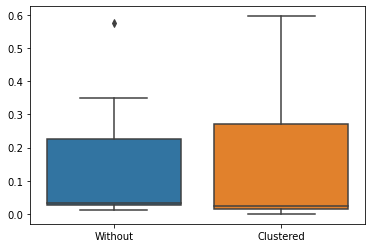

In [ ]:
ax = sns.boxplot(data=[acc_without, acc_coded])
ax.set(xticklabels=['Without', 'Clustered'])

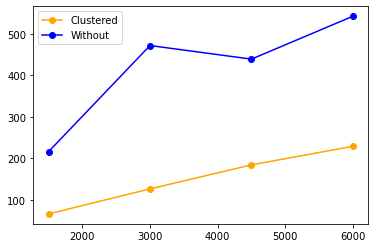

In [ ]:
plt.plot([1500, 3000, 4500, 6000], [65.7, 126.1, 184.1, 228.9], marker='o', color='orange', label='Clustered')
plt.plot([1500, 3000, 4500, 6000], [215.9, 472.1, 439.3, 542.8], marker='o', color='blue', label='Without')
plt.legend()

In [ ]:
for key in bn_dict:
    if key in bn_rename['V']:
        print(key)